In [1]:

from combat.pycombat import pycombat
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference



import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,spearmanr

from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,r2_score

import scanpy as sc



# Utils

## Classes

In [2]:

class BatchEffectAnalyzer:

    def __init__(self, df,metab_num):
        self.df = df
        self.batches = df["batch"].unique()
        self.metab_num=metab_num
        scaler = StandardScaler()
        self.scaled_df = scaler.fit_transform(self.df.iloc[:,:metab_num])
        # self.cal_pvalue_dict()
        # self.diff_size()

    def visualize(self):
        sns.clustermap(self.scaled_df)
        
    def pca(self):
        # f = plt.figure(figsize=(10,6),dpi=300)
        f = plt.figure()
        # PCA
        ax=f.add_subplot(121)
        pca = PCA()
        self.pca_result = pca.fit_transform(self.scaled_df)
        # Plot PCA result
        sns.scatterplot(x=self.pca_result[:,0], y=self.pca_result[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PCA')
        # PLS-DA
        ax=f.add_subplot(122)
        pls = PLSRegression()
        pls.fit(self.scaled_df, self.df['batch'].apply(lambda x: dict(zip(self.df['batch'].values,list(range(len(self.df['batch'].values)))))[x]))
        print("PLS Components:", pls.n_components)
        # Plot PLS-DA result  
        sns.scatterplot(x=pls.x_scores_[:,0], y=pls.x_scores_[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PLS_DA')

    def cal_pvalue_dict(self):
        df=self.df
        label_cols=['batch']
        # delete unwanted
        colnames = self.df.columns[:-2]
        classes=list(dict(sorted(dict(df.value_counts(label_cols[0])).items())).keys())
        print(classes)
        pvalue_dict={}
        if(len(classes)>2):
            for i,colname in enumerate(colnames):
                class_features=[]
                df=df.astype({colname:float})
                for label in classes:
                    tmp_feature=[]
                    # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                    tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                    class_features.append(tmp_feature)

                _, p_value = kruskal(*class_features)
                pvalue_dict[colname]=p_value
        else:
            dfs = {label: df[df[label_cols[0]] == label] for label in classes}
            pvalue_dict = {}
            # apply并行运算
            pvalues = [mannwhitneyu(dfs[classes[0]][col], dfs[classes[1]][col])[1] for col in df.columns[:self.metab_num]]
            pvalue_dict = dict(zip(df.columns, pvalues))
            
        self.pvalue_dict=pvalue_dict
    def diff_size(self):
        r2_scores = []
        for batch in self.batches:
            y = self.df[self.df["batch"]==batch][self.df.columns[0]]
            r2 = r2_score(y, self.scaled_df[:,0])
            r2_scores.append(r2) 
        print("Batch effect sizes:", r2_scores)

## Functions

In [3]:
# Evaluate whether the dataframe before and after tranformation remains the structure
def evaluate_normalization(df_raw, df_normalized,k=''):

    # 计算标准化前后样本spearman相关性
    corr_raw = df_raw.corr(method='spearman')
    corr_normalized = df_normalized.corr(method='spearman')
    
    # 计算相关性矩阵之间的spearmanr
    corr_corr = spearmanr(corr_raw.values.flatten(), corr_normalized.values.flatten())[0]
    if k!='':
        print(f"Sample correlations Spearman r before vs {k}: {corr_corr:.3f}")
    else:    
        print(f"Sample correlations Spearman r before vs after: {corr_corr:.3f}")
    
    return corr_corr
def apply_combat(df,metab_num):
    batch_1_num=df[df['batch']==1].shape[0]
    batch_2_num=df[df['batch']==2].shape[0]
    batch_1_num
    batch_list=[0]*batch_1_num+[1]*batch_2_num
    raw_df=df.iloc[:,:metab_num]
    raw_df=raw_df.T
    corrected_df=pycombat(raw_df,batch_list)
    corrected_df=corrected_df.T
    corrected_df=pd.concat([corrected_df,df.iloc[:,metab_num:]],axis=1)
    consensus_score=evaluate_normalization(df.iloc[:,:metab_num],corrected_df.iloc[:,:metab_num])
    print(f'Consensus score is {consensus_score}')
    return corrected_df
# sum norm a dataframe by samples to avoid variation made by different samples
def apply_sum_norm(df,metab_num):
    raw_data_df=df.iloc[:,:metab_num]
    raw_data_df['sum'] = raw_data_df.sum(axis=1)
    # 求所有sum的平均值 
    avg_sum = raw_data_df['sum'].mean()
    # 计算每行的factor
    raw_data_df['factor'] = avg_sum / raw_data_df['sum'] 
    # 使用factor乘以每行的所有值
    raw_data_df = raw_data_df.drop('sum', axis=1)
    raw_data_df = raw_data_df.multiply(raw_data_df['factor'], axis=0)
    raw_data_df = raw_data_df.drop('factor', axis=1)
    target_df=pd.concat([raw_data_df,df.iloc[:,metab_num:]],axis=1)
    consensus_score=evaluate_normalization(raw_data_df.iloc[:,:metab_num],target_df.iloc[:,:metab_num])
    print(f'Consensus score is {consensus_score}')
    return target_df

def drop_QC_columns(df):
    QC_columns=[]
    for col in df.columns:
        if 'QC' in col:
            QC_columns.append(col)
    return df.drop(columns=QC_columns)

# Preprocess of Data

In [4]:
sample_df=pd.read_csv('../../Subtype/results/20240406/cluster_7e-2.csv',index_col=0)
print(sample_df.shape)
sample_df['batch'] = 1

sample_df.loc[sample_df.index.str.contains("T"), 'batch'] = 2

# Extract the batch column
batch = sample_df['batch']
batch.value_counts()
raw_counts_df=pd.read_csv('../data/rna/counts.csv',index_col=0)
raw_counts_df.index=list(map(str,raw_counts_df.index))
print(raw_counts_df.shape)

(103, 4)


/tmp/ipykernel_671931/4053365039.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_counts_df=pd.read_csv('../data/rna/counts.csv',index_col=0)


(111, 58818)



## Load Data

In [5]:
sample_df=pd.read_csv('../data/metab/cluster_result.csv',index_col=0)
print(sample_df.shape)

# Extract the batch column
batch = sample_df['batch']
batch.value_counts()

raw_counts_df=pd.read_csv('../data/rna/counts.csv',index_col=0)
raw_counts_df.index=list(map(str,raw_counts_df.index))
print(raw_counts_df.shape)

(103, 5)


/tmp/ipykernel_671931/4053664025.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_counts_df=pd.read_csv('../data/rna/counts.csv',index_col=0)


(111, 58818)


In [6]:
# sample_df
# sample_df.to_csv('../data/metab/cluster_result.csv')

In [7]:
sample_df

,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,kmeans_2_clusters,batch
1452,1,1,1,1,1
8339,1,1,1,1,1
5608,1,1,1,1,1
8232,3,3,2,2,1
8775,2,3,2,2,1
...,...,...,...,...,...
140143-T,1,2,1,1,2
190040-T,1,2,1,1,2
190161-T,3,2,2,1,2
200288-T,3,2,2,2,2


## QC of Data

In [8]:
## Filter

# Calculate smallest group size
smallestGroupSize = min(sample_df[sample_df['nmf_2_clusters'] == 1].shape[0],
                        sample_df[sample_df['nmf_2_clusters'] == 2].shape[0])

# Keep columns with sum greater than or equal to smallest group size
keep_cols = raw_counts_df.columns[(raw_counts_df > 20).sum(axis=0) >= smallestGroupSize]


# Filter the DataFrame
rna_counts_df = raw_counts_df[keep_cols]

metab_num = rna_counts_df.shape[1]
print(metab_num)


28048


In [9]:

rna_counts_df=pd.merge(rna_counts_df,sample_df.loc[:,['batch']],left_index=True,right_index=True)


## Batch Effect

/tmp/ipykernel_670530/707876538.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=self.pca_result[:,0], y=self.pca_result[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PCA')
/tmp/ipykernel_670530/707876538.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=pls.x_scores_[:,0], y=pls.x_scores_[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PLS_DA')


PLS Components: 2


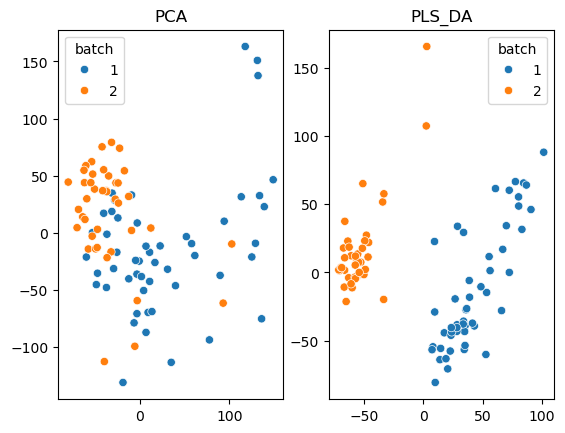

In [10]:
batch_analyzer=BatchEffectAnalyzer(rna_counts_df,metab_num)
batch_analyzer.pca()

In [11]:
corrected_df=apply_combat(rna_counts_df,metab_num)
batch_analyzer=BatchEffectAnalyzer(corrected_df,metab_num)


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [ ]:
corrected_df.shape

(92, 28049)

In [ ]:
# corrected_df.to_csv('../data/rna/pycombatted_counts.csv')

In [ ]:
corrected_df.describe()

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000288611,ENSG00000288612,ENSG00000288616,ENSG00000288617,ENSG00000288622,ENSG00000288631,ENSG00000288632,ENSG00000288637,ENSG00000288638,batch
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,...,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1175.415079,676.809456,1665.966953,1880.281546,405.773737,1465.657556,1126.856252,3594.431860,2522.610787,649.180297,...,96.084079,58.739650,589.520156,72.293010,338.032522,555.864414,454.796791,147.445436,247.300620,1.445652
std,698.211919,257.167950,724.969536,804.957083,527.169897,1663.618577,607.762775,4138.630383,1242.680695,223.505525,...,114.451784,50.916104,912.712185,97.982572,293.023699,650.558073,215.639189,95.661347,345.474282,0.499761
min,-185.630178,131.473166,66.039475,-390.522729,-46.935330,42.422189,195.428271,394.556956,102.680095,120.645846,...,-0.584382,2.990479,49.488985,-0.689079,-3.628167,3.147242,70.543436,14.475854,1.549469,1.000000
25%,673.919510,524.795675,1353.358893,1457.900736,130.677916,439.884174,673.657796,1573.098369,1684.913527,499.159035,...,26.541400,26.401778,211.518996,6.989956,136.632316,247.163446,317.469022,84.454889,31.325909,1.000000
50%,1039.209057,647.415081,1649.310886,1888.034816,240.337112,875.597115,1049.331154,2282.780578,2387.139748,647.924392,...,49.464238,41.444922,343.659102,32.811949,250.078033,354.405815,406.093367,128.562329,111.266558,1.000000
75%,1549.056405,805.064308,1956.568506,2393.913690,512.297043,1549.636020,1468.965910,3711.920772,3119.794125,812.515477,...,144.333574,78.485596,621.474407,97.758973,415.581091,627.054180,574.279035,184.735469,355.896430,2.000000
max,3747.517767,1364.659521,5900.576121,3919.119715,3649.741200,8179.111210,3479.551137,29177.019759,7943.112227,1264.781086,...,635.888950,272.277905,6511.040594,575.829305,1157.649550,4277.032177,1385.599556,562.867416,2261.103787,2.000000


/tmp/ipykernel_641343/707876538.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=self.pca_result[:,0], y=self.pca_result[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PCA')
/tmp/ipykernel_641343/707876538.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=pls.x_scores_[:,0], y=pls.x_scores_[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PLS_DA')


PLS Components: 2


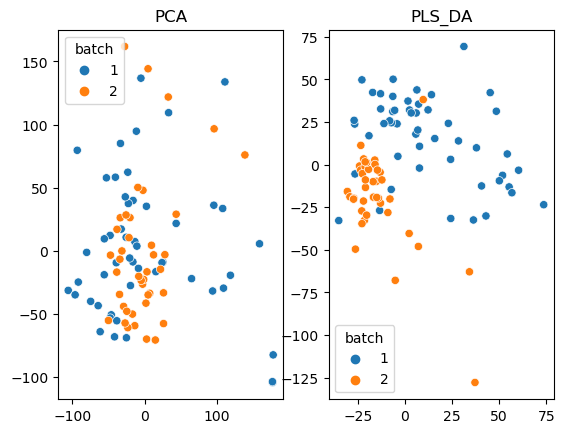

In [ ]:
batch_analyzer=BatchEffectAnalyzer(corrected_df,metab_num)

batch_analyzer.pca()

In [ ]:
corrected_df.values.reshape(())

array([[2.85383850e+02, 1.34193930e+02, 1.27486966e+02, ...,
        1.82894256e+01, 2.89696806e+01, 1.00000000e+00],
       [5.23815776e+02, 6.05566321e+02, 1.46592504e+03, ...,
        1.67018709e+02, 3.37635657e+02, 1.00000000e+00],
       [1.39625987e+03, 6.93310965e+02, 2.18653652e+03, ...,
        8.08319959e+01, 3.13259094e+01, 1.00000000e+00],
       ...,
       [8.88847838e+02, 7.16237716e+02, 1.37857291e+03, ...,
        2.33914307e+02, 6.80819208e+02, 2.00000000e+00],
       [8.43815231e+02, 7.32282257e+02, 1.72026629e+03, ...,
        1.36031789e+02, 4.11038319e+02, 2.00000000e+00],
       [1.13832848e+03, 9.45083533e+02, 1.32031984e+03, ...,
        3.73610716e+02, 2.32282907e+01, 2.00000000e+00]])

## Median-Norm by DESEQ

In [14]:
combatted_df=pd.read_csv('../data/rna/pycombatted_counts.csv',index_col=0)
combatted_df=combatted_df.iloc[:,:-1]
combatted_df=round(combatted_df)
combatted_df=combatted_df.astype(np.int32)
combatted_df.index=list(map(str,combatted_df.index.tolist()))


/tmp/ipykernel_671931/931858346.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  combatted_df=pd.read_csv('../data/rna/pycombatted_counts.csv',index_col=0)


In [21]:
neg_colnames=combatted_df.columns[(combatted_df<0).any()]
for col in neg_colnames:
    print(min(combatted_df.loc[combatted_df[col]>=0,col].values))
    combatted_df.loc[combatted_df[col]<0,col]=min(combatted_df.loc[combatted_df[col]>=0,col].values)

### Combat + DESEQ

In [22]:
using_df=pd.merge(raw_counts_df,sample_df,left_index=True,right_index=True)
kmeans_metadata=pd.DataFrame(zip(using_df.index,using_df['kmeans_2_clusters'],using_df['batch']),columns=['Sample','kmeans_2_clusters','batch'])
nmf_metadata=pd.DataFrame(zip(using_df.index,using_df['nmf_2_clusters'],using_df['batch']),columns=['Sample','nmf_2_clusters','batch'])
nmf_metadata = nmf_metadata.set_index('Sample')


In [23]:
combatted_df.index

Index(['1277', '1452', '1520', '1775', '1870', '2039', '2139', '2208', '2257',
       '2423', '2480', '2663', '2667', '2669', '2706', '2707', '2739', '2877',
       '2984', '3243', '3334', '4059', '4202', '4254', '4876', '4931', '5058',
       '5078', '5608', '5759', '6137', '6176', '6625', '6808', '6864', '6927',
       '7038', '7311', '7970', '7991', '8024', '8105', '8232', '8288', '8339',
       '8410', '8418', '8575', '8711', '8775', '8816', '120155-T', '120342-T',
       '120367-T', '120412-T', '130010-T', '130197-T', '130222-T', '140143-T',
       '140263-T', '140389-T', '150099-T', '150230-T', '150245-T', '150342-T',
       '154264-T', '160087-T', '160115-T', '160143-T', '160229-T', '170046-T',
       '170116-T', '170134-T', '170195-T', '170265-T', '170282-T', '180118-T',
       '180224-T', '190040-T', '190069-T', '190149-T', '190161-T', '196633-T',
       '200095-T', '200097-T', '200128-T', '200131-T', '200288-T', '200297-T',
       '210011-T', '222836-T', '271431-T'],
      dt

In [24]:
inference = DefaultInference(n_cpus=64)
nmf_dds = DeseqDataSet(
    counts=combatted_df.loc[nmf_metadata.index,:],
    metadata=nmf_metadata,
    design_factors=nmf_metadata.columns.tolist(),
    refit_cooks=True,
    inference=inference
)
nmf_dds.deseq2()


/tmp/ipykernel_671931/450920976.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  nmf_dds = DeseqDataSet(
Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 3.81 seconds.

Fitting dispersion trend curve...
... done in 0.60 seconds.

Fitting MAP dispersions...
... done in 4.37 seconds.

Fitting LFCs...
... done in 2.87 seconds.

Replacing 665 outlier genes.

Fitting dispersions...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 0.42 seconds.

Fitting LFCs...
... done in 0.45 seconds.



#### DE Analysis

In [26]:
test_df=pd.DataFrame(nmf_dds.layers['normed_counts'],index=nmf_dds.obs_names,columns=nmf_dds.var_names)
using_df=pd.merge(test_df,sample_df,left_index=True,right_index=True)
using_df.groupby('kmeans_2_clusters').mean()

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000288617,ENSG00000288622,ENSG00000288631,ENSG00000288632,ENSG00000288637,ENSG00000288638,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,batch
kmeans_2_clusters,,,,,,,,,,,,,,,,,,,,,
1,1072.448271,646.931940,1662.999393,1999.256526,301.723353,930.961690,892.431498,2614.665126,2456.608051,639.021103,...,72.006817,307.794388,665.000215,434.062912,148.324382,238.974319,1.392157,1.686275,1.27451,1.450980
2,1189.056329,645.793143,1529.708720,1637.922395,522.068558,1860.273188,1283.534091,4425.287642,2250.375888,613.605113,...,65.996296,359.733505,471.095598,453.879834,131.816744,222.820555,2.707317,2.536585,2.00000,1.439024


In [27]:
nmf_stat_res = DeseqStats(nmf_dds,  contrast = ('nmf-2-clusters','1','2'),inference=inference)
nmf_stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: nmf-2-clusters 1 vs 2
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003  1124.414906       -0.329795  0.155306 -2.123521  0.033710   
ENSG00000000419   646.424433        0.003710  0.087632  0.042340  0.966228   
ENSG00000000457  1603.598115        0.149020  0.126604  1.177055  0.239174   
ENSG00000000460  1838.227185        0.273029  0.122670  2.225720  0.026033   
ENSG00000000938   399.920673       -1.174556  0.312905 -3.753717  0.000174   
...                      ...             ...       ...       ...       ...   
ENSG00000288622   330.941169        0.041798  0.241927  0.172772  0.862830   
ENSG00000288631   578.586201       -0.203264  0.277128 -0.733465  0.463275   
ENSG00000288632   442.894366       -0.016643  0.130092 -0.127934  0.898201   
ENSG00000288637   140.967717        0.145280  0.172301  0.843175  0.399131   
ENSG00000288638   231.775359       -0.304623  0.376460 -0.809178  0.418413   

   

... done in 2.01 seconds.



In [29]:
rna_nmf_stat_df=nmf_stat_res.results_df

In [31]:
pvalue_cutoff=5e-2
fc_up_cutoff=2
fc_down_cutoff=1/fc_up_cutoff

rna_nmf_stat_df['is_use']=(rna_nmf_stat_df['padj']<pvalue_cutoff)&(abs(rna_nmf_stat_df['log2FoldChange'])>np.log2(fc_up_cutoff))


(1296, 6)

In [32]:
rna_nmf_stat_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,is_use
ENSG00000000003,1124.414906,-0.329795,0.155306,-2.123521,0.033710,0.118907,False
ENSG00000000419,646.424433,0.003710,0.087632,0.042340,0.966228,0.983580,False
ENSG00000000457,1603.598115,0.149020,0.126604,1.177055,0.239174,0.430472,False
ENSG00000000460,1838.227185,0.273029,0.122670,2.225720,0.026033,0.099195,False
ENSG00000000938,399.920673,-1.174556,0.312905,-3.753717,0.000174,0.002801,True
...,...,...,...,...,...,...,...
ENSG00000288622,330.941169,0.041798,0.241927,0.172772,0.862830,0.928581,False
ENSG00000288631,578.586201,-0.203264,0.277128,-0.733465,0.463275,0.648540,False
ENSG00000288632,442.894366,-0.016643,0.130092,-0.127934,0.898201,0.947093,False
ENSG00000288637,140.967717,0.145280,0.172301,0.843175,0.399131,0.592599,False


In [33]:
# rna_nmf_stat_df.to_csv('../results/20240518_combat_deseq/rna_nmf_stat.csv')

### Raw DESEQ

In [90]:
using_df=pd.merge(raw_counts_df,sample_df,left_index=True,right_index=True)

In [57]:
kmeans_metadata=pd.DataFrame(zip(using_df.index,using_df['kmeans_2_clusters'],using_df['batch']),columns=['Sample','kmeans_2_clusters','batch'])
nmf_metadata=pd.DataFrame(zip(using_df.index,using_df['nmf_2_clusters'],using_df['batch']),columns=['Sample','nmf_2_clusters','batch'])
nmf_metadata = nmf_metadata.set_index('Sample')


### Build DESEQ Dataset

In [93]:
inference = DefaultInference(n_cpus=64)
nmf_dds = DeseqDataSet(
    counts=raw_counts_df.loc[nmf_metadata.index,:],
    metadata=nmf_metadata,
    design_factors=nmf_metadata.columns.tolist(),
    refit_cooks=True,
    inference=inference
)
nmf_dds.deseq2()


/tmp/ipykernel_650026/3131753993.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  nmf_dds = DeseqDataSet(
Fitting size factors...
... done in 0.11 seconds.

Fitting dispersions...
... done in 7.14 seconds.

Fitting dispersion trend curve...
... done in 1.30 seconds.

Fitting MAP dispersions...
... done in 7.87 seconds.

Fitting LFCs...
... done in 6.23 seconds.

Replacing 5279 outlier genes.

Fitting dispersions...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 0.68 seconds.

Fitting LFCs...
... done in 0.89 seconds.



In [94]:
nmf_dds

AnnData object with n_obs × n_vars = 92 × 58818
    obs: 'nmf-2-clusters', 'batch'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

### Batch Effect Comporison

In [96]:
test_df=pd.DataFrame(nmf_dds.layers['normed_counts'],index=nmf_dds.obs_names,columns=nmf_dds.var_names)
using_df=pd.merge(test_df,sample_df,left_index=True,right_index=True)
# using_df.groupby('kmeans_2_clusters').mean()
batch_analyzer=BatchEffectAnalyzer(using_df,nmf_dds.layers['normed_counts'].shape[1])
batch_analyzer.pca()

PLS Components: 2


/tmp/ipykernel_671145/707876538.py:23: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=self.pca_result[:,0], y=self.pca_result[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PCA')
/tmp/ipykernel_671145/707876538.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=pls.x_scores_[:,0], y=pls.x_scores_[:,1], hue=self.df["batch"],palette=sns.color_palette()).set(title='PLS_DA')


Text(0.5, 0.98, 'Combat')

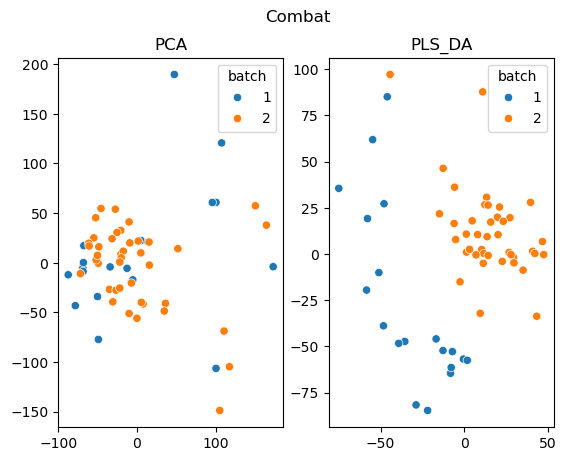

In [17]:
using_df=pd.merge(combatted_df,sample_df,left_index=True,right_index=True)
# using_df.groupby('kmeans_2_clusters').mean()
batch_analyzer=BatchEffectAnalyzer(using_df,combatted_df.shape[1])
batch_analyzer.pca()
plt.suptitle("Combat")

In [23]:
# with open('../results/20240515/rna_dds.pkl', 'wb') as f:
#     pickle.dump(dds, f)
# save_df=pd.DataFrame(dds.layers['normed_counts'],index=dds.obs_names,columns=dds.var_names)
# save_df.to_csv('../data/rna/deseqed_counts.csv')


# DE Analysis

In [24]:
with open('../results/20240515/rna_dds.pkl', 'rb') as f:
    dds = pickle.load(f)

## Statistics

In [62]:
dds

AnnData object with n_obs × n_vars = 92 × 58818
    obs: 'nmf-2-clusters', 'batch'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

In [63]:
test_df=pd.DataFrame(dds.layers['normed_counts'],index=dds.obs_names,columns=dds.var_names)
using_df=pd.merge(test_df,sample_df,left_index=True,right_index=True)
using_df.groupby('kmeans_2_clusters').mean()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288638,ENSG00000288639,ENSG00000288640,ENSG00000288642,ENSG00000288644,ENSG00000288645,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,batch
kmeans_2_clusters,,,,,,,,,,,,,,,,,,,,,
1,1073.679319,9.701479,593.316861,1583.489400,1932.097571,297.137898,886.970025,803.131577,2432.130874,2412.418359,...,223.966145,0.365388,23.661688,1.338798,0.935519,5.666419,1.392157,1.686275,1.27451,1.450980
2,1166.661680,10.280676,607.031288,1523.896137,1601.198263,490.880629,1782.672067,1252.026853,4266.838893,2212.317754,...,216.891557,0.332038,45.944981,1.325584,0.893190,3.914644,2.707317,2.536585,2.00000,1.439024


In [27]:
np.log2(1166.661680/1073.679319	)

0.11982309388504718

In [64]:
nmf_stat_res = DeseqStats(dds,  contrast = ('nmf-2-clusters','1','2'),inference=inference)
nmf_stat_res.summary()


Running Wald tests...
... done in 4.10 seconds.



Log2 fold change & Wald test p-value: nmf-2-clusters 1 vs 2
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003  1115.117110       -0.406638  0.205917 -1.974762  0.048295   
ENSG00000000005     9.959599       -0.518767  0.433759 -1.195980  0.231704   
ENSG00000000419   599.428725       -0.038130  0.151984 -0.250883  0.801905   
ENSG00000000457  1556.931533        0.058189  0.112972  0.515074  0.606501   
ENSG00000000460  1784.631575        0.244376  0.180928  1.350681  0.176798   
...                      ...             ...       ...       ...       ...   
ENSG00000288639     0.350525        0.243533  0.577781  0.421497  0.673392   
ENSG00000288640    33.592286       -0.056410  1.276403 -0.044195  0.964749   
ENSG00000288642     0.742160        2.202710  2.760343  0.797984  0.424880   
ENSG00000288644     0.916655        0.053578  0.331772  0.161489  0.871708   
ENSG00000288645     4.885736        0.403351  0.331907  1.215254  0.224269   

   

In [ ]:
kmeans_stat_res = DeseqStats(dds,  contrast = ('kmeans-2-clusters','1','2'),inference=inference)
kmeans_stat_res.summary()

In [65]:
rna_nmf_stat_df=nmf_stat_res.results_df
rna_kmeans_stat_df=kmeans_stat_res.results_df
# rna_stat_result_df = rna_stat_result_df[rna_stat_result_df.baseMean >= 10]
# rna_nmf_stat_df.to_csv('../results/20240515/nmf_rna_stat.csv')
# rna_kmeans_stat_df.to_csv('../results/20240515/kmeans_rna_stat.csv')

### Significant Filter

In [66]:
pvalue_cutoff=5e-2
fc_up_cutoff=2
fc_down_cutoff=1/fc_up_cutoff

sig_df=rna_nmf_stat_df[(rna_nmf_stat_df['padj']<pvalue_cutoff)&(abs(rna_nmf_stat_df['log2FoldChange'])>np.log2(fc_up_cutoff))]
sig_df.shape

## Plots

In [44]:
dds

AnnData object with n_obs × n_vars = 92 × 58818
    obs: 'nmf-2-clusters', 'kmeans-2-clusters', 'batch'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks', 'log1p'

In [72]:
sc.pl.pca(dds, color = 'nmf-2-cluster', size = 200)

KeyError: "Could not find 'pca' or 'X_pca' in .obsm"

In [39]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
sig_dds=dds[:,sig_df.index]

NameError: name 'sig_df' is not defined

In [111]:
dds.obs.batch.values

['1', '1', '1', '1', '1', ..., '2', '2', '2', '2', '2']
Length: 92
Categories (2, object): ['1', '2']

In [126]:
grapher = pd.DataFrame(sig_dds.layers['log1p'].T,
                       index=sig_dds.var_names, columns=sig_dds.obs_names)
col_dict={'1':'red','2':'blue'}
col_colors=list(map(lambda x:col_dict[x],list(sig_dds.obs.batch.values)))

/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


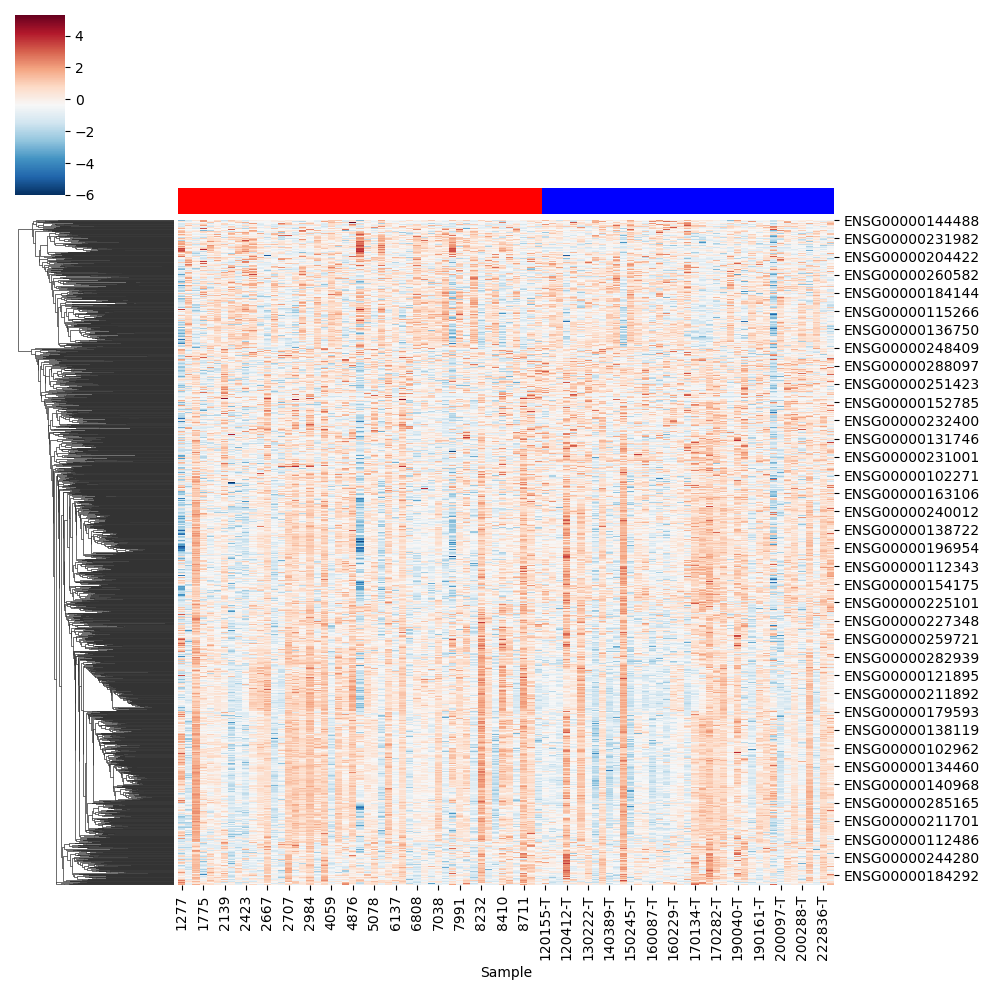

In [128]:
sns.clustermap(grapher, z_score=0,col_cluster=False,col_colors=col_colors,cmap = 'RdBu_r',)
